# Gaussian Processes

Based on code from: http://www.cs.ubc.ca/~nando/540-2013/lectures/gp.py

Also referenced: 

* http://bridg.land/posts/gaussian-processes-1
* https://www.youtube.com/watch?v=4vGiHC35j9s
* "Gaussian Processes for Machine Learning" book

Key idea: as mentioned in these [two](https://www.youtube.com/watch?v=50Vgw11qn0o) [lectures](https://www.video.ethz.ch/conferences/2014/rnls/05_thursday/0f8953ea-b1fe-4960-8fa1-ef71bb642445.html), we use Gaussians to represent things because they make the math easy, and the assumptions we have to make to model real stuff as Gaussians are reasonable enough (same reason we assume linear dynamical systems). Gaussians turn marginalization and conditioning into linear algebra, which is why "Gaussian Processes are the linear algebra of inference". Simple matrix multiplications and inverses give us probabilistic inference of joint probability distributions.

Model $p(\mathbf{y}\vert\mathbf{x})$ using a multivariate normal:

$$p(\mathbf{y}\vert\mathbf{x})=\mathcal{N}(\mathbf{y}\vert m(\mathbf{x}),\mathbf{K})$$

where $\mathbf{K}=\kappa(\mathbf{x}, \mathbf{x})$ and $m(\mathbf{x})=\mathbf{0}$. When we assume zero-mean, the GP is completely defined by the covariance function $\mathbf{K}$.

This is a prior distribution representing the kind of outputs $\mathbf{y}$ that we expect to see over some inputs $\mathbf{x}$ _before_ we observe any data.

So we have some training data with inputs $\mathbf{x}$, and outputs $\mathbf{y}=f(\mathbf{x})$. Now lets say we have some new points $\mathbf{x}_*$ where we want to predict $\mathbf{y}_*=f(\mathbf{x}_*)$

GPs are non-parametric; as in, they don't specify a set of parameters for the function (e.g. linear regression $y=w^Tx$, neural networks/others $y=f(\theta, x)$). The way I think of it is: in GPs, every data point from the training set becomes a basis function. See Section 2.2 in Rasmussen book for illustration of this

Wikipedia explains it well [here](https://en.wikipedia.org/wiki/Nonparametric_statistics): "The second meaning of non-parametric covers techniques that do not assume that the structure of a model is fixed. Typically, the model grows in size to accommodate the complexity of the data", "The term non-parametric is not meant to imply that such models completely lack parameters but that the number and nature of the parameters are flexible and not fixed in advance." This means that unlike parametric methods like neural networks, GPs can grow in flexibility as more data is added to effectively "memorize" all the training data. 

Note: GPs are a specific instantiation of kernel method, where the Gaussian form allows closed-form solutions for most operations. 

Another interpretation that made sense to me from Wikipedia: "A machine-learning algorithm that involves a Gaussian process uses lazy learning and a measure of the similarity between points (the kernel function) to predict the value for an unseen point from training data." "Ultimately Gaussian processes translate as taking priors on functions and the smoothness of these priors can be induced by the covariance function. If we expect that for "near-by" input points x and x' their corresponding output points y and y' to be "near-by" also, then the assumption of continuity is present. If we wish to allow for significant displacement then we might choose a rougher covariance function. Extreme examples of the behaviour is the Ornstein–Uhlenbeck covariance function and the squared exponential where the former is never differentiable and the latter infinitely differentiable."

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

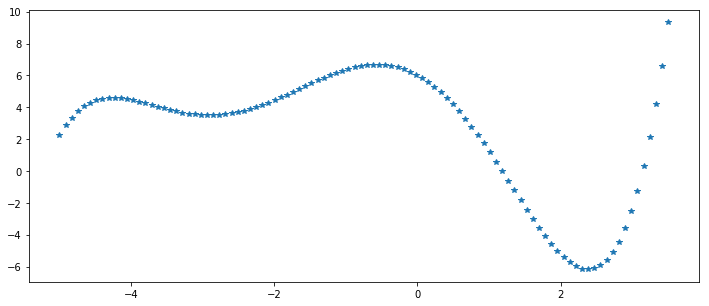

In [2]:
# Real function to approximate
# xs = np.linspace(-7, 7, 100)
# plt_range = [-7, 7, -3, 3]
# f = lambda x: np.sin(0.9*x).flatten()

# Another function to try: 5th order polynomial 
# Note that you'll have to change bounds on the plots, as well as samples for training
# coefs[i] is the coefficient of x^i
xs = np.linspace(-5.0, 3.5, 100)
plt_range = [-5, 3.5, -10, 15]
coefs = np.array([6, -2.5, -2.4, -0.1, 0.2, 0.03])
def f(x):
    total = 0
    for exp, coef in enumerate(coefs):
        total += coef * (x ** exp)
    return total.flatten()

ys = f(xs)

fig, ax = plt.subplots(figsize=(12, 5))
plt.plot(xs, ys, '*')
plt.show()

### GP fit

The kernel function acts as a prior on our function. Here, we assume smoothness and encode this in the kernel:

$$ \kappa(x, x')=\sigma^2\exp\left(-~\frac{(x-x')^2}{2l}\right)$$

This function is 1 when $x=x'$ and tends to zero as its arguments drift apart. It encourages the gaussian process to have similar valued outputs for similar valued inputs. Note that this function is infinitely differentiable.

Note that this is where design choices and hyperparameter tuning fall in GPs; kernels encode assumptions/background knowledge about the data. The hyperparameters can also be optimized with maximization of the marginal likelihood (some form of gradient descent). See slide 23 [here](https://people.cs.umass.edu/~wallach/talks/gp_intro.pdf)

In [17]:
""" 
GP squared exponential kernel 
"""
def se_kernel(a, b):
    kernelParameter = 0.5 # horizontal scale
    sigma = 1 # vertical variation
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return sigma**2 * np.exp(-0.5 * (1/kernelParameter) * sqdist)

In [4]:
n_train = 5         # number of training points.
n = 50         # number of test points.
s = 5e-5    # noise variance.

In [5]:
"Construct function from random sample/training points along reference function"
# Sample some input points and noisy version of the function evaluated at these points. 
X = np.random.uniform(-5, 5, size=(n_train,1)) 
y = f(X) + s*np.random.randn(n_train)

K = se_kernel(X, X)
L = np.linalg.cholesky(K + s*np.eye(n_train))

We represent the covariance matrix with its cholesky decomposition because it makes later operations (sampling from distribution, inverting covariance matrix) more efficient. 

The following math is from Rasmussen pg 16.

##### Computing the mean at test points

Want to do: $\mu = K_* K^{-1} y$, where $K=k(X_\text{train}, X_\text{train})$ and $K_*=k(X_\text{train}, X_\text{test})$

Trying to find an intuition for this: 

* $y$ $n_\text{train} \times n_\text{dims}$ (training data)
* $K$ $n_\text{train} \times n_\text{train}$ (covariance matrix of training data - inverse is information matrix)
    * $K^{-1}y$ : extract salient features from y?
* $K_*$ $n_\text{test} \times n_\text{train}$ (covariance between test and train data)
    * project what we know about the training data onto the test set

$K = L L^T \rightarrow K^{-1} = L^{-T} L^{-1}$

$L_k = L^{-1} K_*$

$L_k^T = K^{T}_* L^{-T}$

$\mu = K_* L^{-T} L^{-1} y = K_* K^{-1} y$

##### Computing the variance at test points

TODO clarify this

$K\_ = k(X_\text{test}, X_\text{test})$

$diag(K\_)$ is vector of variances

$L_k^2$ is element-wise square

$L_k = L^{-1} K_*$

$L_k^2 = (L^{-1})^2 (K_*)^2$

In [6]:
# points we're going to make predictions at.
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# compute the mean at our test points.
Lk = np.linalg.solve(L, se_kernel(X, Xtest))
mu = np.dot(Lk.T, np.linalg.solve(L, y))

# compute the variance at our test points
# Lk is size (10, 50), sum returns (50,)
K_ = se_kernel(Xtest, Xtest)
s2 = np.diag(K_) - np.sum(Lk**2, axis=0) #math trick
s = np.sqrt(s2)

# Compute full covariance matrix, then take diagonal to get variance
# Produces same results as calculation above
# cov(all points) = K** - (K* K^{-1} K*) 
# K is covariance of GP, defined by kernel
# Note that this is less inefficient and inaccurate; doesn't use Cholesky
# See below for correct way to compute this
Kinv = np.linalg.inv(K)
K2 = K_ - (np.matmul(se_kernel(Xtest, X), np.matmul(Kinv, se_kernel(X, Xtest))))

# Note that doing it the first way results in some numerical errors
K2 = K_ - np.dot(Lk.T, Lk) + 1e-6*np.eye(n)

s2_2 = np.diag(K2)
s_2 = np.sqrt(s2_2)

In [7]:
# Trying to make plot that is similar to plots in papers for DMPs and POMDPs, by summing up Gaussian basis functions
from scipy.stats import norm

"utility function for plotting gaussians around each data point"
def plot_gaussian(coord, mean, std, zero_height=0):
    x = np.linspace(norm.ppf(0.0001), norm.ppf(0.9999), 100)
    plt.plot(x+coord, mean*norm.pdf(x, 0, std)+zero_height, 'g-', lw=0.5)

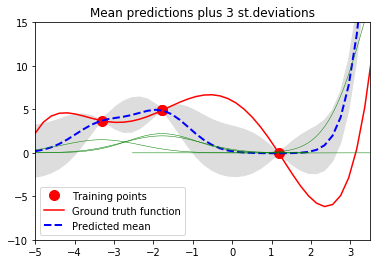

In [8]:
# PLOTS:
plt.plot(X, y, 'r.', ms=20)
plt.plot(Xtest, f(Xtest), 'r-')
plt.plot(Xtest, mu, 'b--', lw=2)
plt.gca().fill_between(Xtest.flat, mu-3*s, mu+3*s, color="#dddddd") #variances from shortcut trick
# plt.gca().fill_between(Xtest.flat, mu-3*s_2, mu+3*s_2, color="#ddddd0") #variances from full covariance matrix
plt.title('Mean predictions plus 3 st.deviations')
plt.axis(plt_range)

# Plot Gaussians at each test point, to show interpretation that GP mean is 
# weighted sum of Gaussians from each data point
xg_total = 0
yg_total = 0
for i,x in enumerate(X):
    coord = x[0]
    mean = y[i]
    var = K2[i, i]
    plot_gaussian(coord, mean, np.sqrt(var), 0)
    
plt.legend(['Training points', 'Ground truth function', 'Predicted mean'])

Note that each test point (red plus signs) becomes a Gaussian "basis function" for the mean of the GP (green bell curves). The mean is the sum of all of these Gaussians (this is how DMPs, ProMPs work). 

---

##### Aside: sampling from distribution specified by covariance 

The covariance matrix is $\sigma^2$, and the Cholesky decomposition gives you the "square root" of the (positive definite) original matrix. 

$$A = LL^T$$
Where $L$ is lower triangular with positive diagonal elements. 

Recall that the definition of the covariance matrix is the outer product $\Sigma = (x-\mu)(x-\mu)^T$

From wikipedia: "The Cholesky decomposition is commonly used in the Monte Carlo method for simulating systems with multiple correlated variables. The correlation matrix is decomposed, to give the lower-triangular L. Applying this to a vector of uncorrelated samples u produces a sample vector Lu with the covariance properties of the system being modeled."

You can sample random points from a Gaussian distribution given $(\mu, \Sigma)$, using the Cholesky decomposition. The random points can be sampled with: 
$$ p = \mu + LX$$
Where $X$ is a matrix of size $n \times k$, $k$ being the number of samples. Each column of $X$ is drawn from a normal distribution $N(0,1)$

The covariance of the points generated by this method are calculated as: 
$$\Sigma_\text{sample} = (LX)(LX)^T = LXX^TL^T = L(XX^T)L^T$$
$XX^T \approx I$ because the vectors are taken from a normal distribution; therefore, $\Sigma_\text{sample} = \Sigma$

In [9]:
# Testing random samples from distribution with Cholesky
np.set_printoptions(suppress=True, precision=4)

Sigma = np.array([[2, 0.5], [0.5, 1]])
print('Original covariance:\n', Sigma)
L_rand = np.linalg.cholesky(Sigma)

np.random.seed()
num_samples = 100000
Rand = np.random.normal(size=(2, num_samples))
p = np.matmul(L_rand, Rand) # assume zero mean

print('Sample covariance:\n', np.cov(p))
print('Random seed covariance (expect identity): \n', np.cov(Rand))

Original covariance:
 [[2.  0.5]
 [0.5 1. ]]
Sample covariance:
 [[1.998  0.5019]
 [0.5019 1.0052]]
Random seed covariance (expect identity): 
 [[0.999  0.0018]
 [0.0018 1.0047]]


---

##### Multivariate Gaussian Theorem

See Rasmussen chapter 2

$$\mu=\begin{bmatrix}\mu_1 \\ \mu_2 \end{bmatrix}, \Sigma = \begin{bmatrix} \Sigma_{11} & \Sigma_{12} \\ \Sigma_{21} & \Sigma_{22}\end{bmatrix}$$

Marginals: 
$$p(x_1|x_2)=N(x_1 \vert \mu_{1|2}, \Sigma_{1|2})$$
$$\mu_{1|2} = \mu_1 + \Sigma_{12}\Sigma_{22}^{-1}(x_2-\mu_2)$$
$$\Sigma_{1|2} = \Sigma_{11}-\Sigma_{12}\Sigma_{22}^{-1}\Sigma_{21}$$

This section from: http://bridg.land/posts/gaussian-processes-1

Now recalling the definition of a GP, we will model the joint distribution of all of $\mathbf{y}$ and $\mathbf{y}_*$ as:

$$ \begin{pmatrix}\mathbf{y} \\ \mathbf{y}_*\end{pmatrix} \sim\mathcal{N}\left(\begin{pmatrix}m(\mathbf{x})\\ m(\mathbf{x}_*)\end{pmatrix}, \begin{pmatrix}\mathbf{K} & \mathbf{K}_* \\ \mathbf{K}_*^T & \mathbf{K}_{**}\end{pmatrix}\right) $$

where $\mathbf{K}=\kappa(\mathbf{x}, \mathbf{x})$, $\mathbf{K}_* = \kappa(\mathbf{x}, \mathbf{x}_*)$ and $\mathbf{K}_{**}=\kappa(\mathbf{x}_*, \mathbf{x}_*)$. As before we are going to stick with a zero mean.

However this is modeling $p(\mathbf{y}, \mathbf{y}_*\vert \mathbf{x}, \mathbf{x}_*)$ and we only want a distribution over $\mathbf{y}_*$! 

We want: $p(\mathbf{y}_* \ \vert \  m(\mathbf{x}_*), \mathbf{K}_*)$

Unknowns: $m(\mathbf{x}_*), \mathbf{K}_*$

Knowns: $\mathbf{x}, \mathbf{x}_*, m(\mathbf{x}), \mathbf{y}, \mathbf{K}, \mathbf{K}_*, \mathbf{K}_{**}$.

TODO try to color equation above to distinguish knowns/unknowns

### Conditioning Multivariate Gaussians

Rather than deriving it from scratch we can just make use of [this standard result](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions). If we have a joint distribution over $\mathbf{y}$ and $\mathbf{y}_*$ as above, and we want to condition on the data we have for $\mathbf{y}$ then we have the following:

$$\begin{align}
p(\mathbf{y}_*\vert \mathbf{x}_*, \mathbf{x}, \mathbf{y})&=\mathcal{N}(\mathbf{y}_*\vert \mu_*, \Sigma_*)\\
\mu_*&=m(\mathbf{x}_*)+\mathbf{K}_*^T\mathbf{K}^{-1}(\mathbf{y}-m(\mathbf{x}))\\
\Sigma_*&=\mathbf{K}_{**}-\mathbf{K}_*^T\mathbf{K}^{-1}\mathbf{K}_*
\end{align}$$

Now we have a posterior distribution over $\mathbf{y}_*$ using a prior distribution and some observations!

[-5, 3.5, -10, 15]

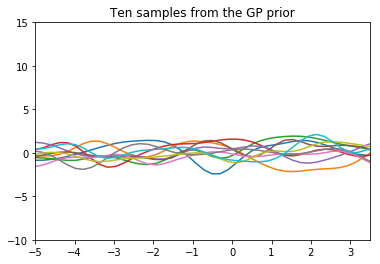

In [10]:
# draw samples from the prior at our test points.
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n))
f_prior = np.dot(L, np.random.normal(size=(n,10)))

plt.plot(Xtest, f_prior)
plt.title('Ten samples from the GP prior')
plt.axis(plt_range)

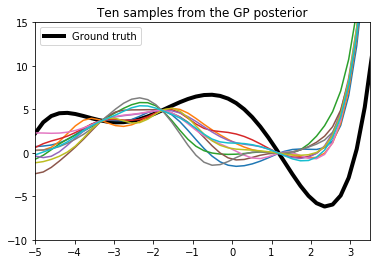

In [11]:
# Draw samples from the posterior at our test points.

# Calculate posterior covariance matrix
# K_posterior = K(Xtest,Xtest) - K(Xtest,X)K^{-1}K(X,Xtest)
# Add small value on diagonal to make sure it's positive definite
L = np.linalg.cholesky(K_ - np.dot(Lk.T, Lk) + 1e-6*np.eye(n))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,10)))

plt.plot(Xtest, f(Xtest), 'k-', lw=4) # Real function
plt.plot(Xtest, f_post)
plt.title('Ten samples from the GP posterior')
plt.axis(plt_range)
plt.legend(['Ground truth'])

### Moving forward: stuff to consider

* How to pick kernel? This always needs to be hand-picked
* How to pick kernel parameters? These reflect our prior belief on the data. There are methods to do this
* We also have an assumed noise variance in the GP formulation

### Modeling the Rastrigin function

The Rastrigin function is commonly used as an example for optimization problems where gradient descent fails to find a good minimum (global). Here, we'll just use it as a "wavy shape" to see if a Gaussian process can fit it. 

In n-dimensional domain, it is defined by: 
$$f(x) = An + \sum^n_{i=1}[x_i^2-Acos(2\pi x_i)]$$

Global minimum is $x=0$, where $f(x)=0$.

Set $A=10$, $n=2$, $x\in[-5.12, 5.12]$ to copy wikipedia's example

In [12]:
from matplotlib import cm #colormap
import math #pi
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
# so 3d plots are interactive
# %matplotlib notebook 
# from ipykernel.pylab.backend_inline import flush_figures

In [13]:
def rastrigin(X, A=3):
    return A + sum([(x**2 - A * np.cos(2 * math.pi * x)) for x in X])

In [14]:
# TODO find a better way to do this. meshgrid?
def xy_combinations(X, Y):
    # Make a matrix of (x,y) coordinates for scatter3d for two vectors X,Y
    XY_plot = np.zeros((X.size*Y.size, 2)) # each row will be one point, so Nx2
    i = 0
    for x in X:
        for y in Y:
            XY_plot[i, :] = np.array([x, y])
            i += 1
    return XY_plot

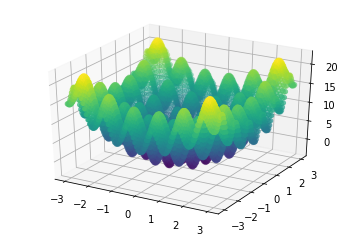

In [15]:
# Plot reference function
X_plot = np.linspace(-3, 3, 100)    
Y_plot = np.linspace(-3, 3, 100)    
X2, Y2 = np.meshgrid(X_plot, Y_plot)
Z = rastrigin(X2, Y2)
        
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.plot_surface(X2, Y2, Z, rstride=1, cstride=1, linewidth=0, antialiased=False)#, cmap=cm.plasma) 

XY_plot = xy_combinations(X_plot, Y_plot)
Z = rastrigin(XY_plot.T)
ax.scatter3D(XY_plot[:,0], XY_plot[:,1], Z, c=Z, cmap='viridis')

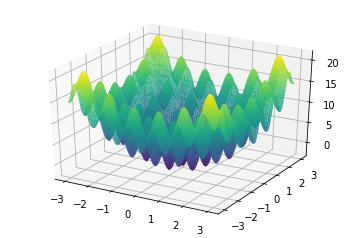

In [16]:
# Alternative plot: trisurf
# Creates surface by finding a set of triangles formed between adjacent points
# (x,y,z) can be 1D arrays instead of rectilinear. samples can be random
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(XY_plot[:,0], XY_plot[:,1], Z, cmap='viridis')

In [17]:
# grid training points
# N = 5
# X = np.linspace(-3, 3, N)    
# Y = np.linspace(-3, 3, N)   

# random training points
n_train = 30
X = np.random.uniform(-3, 3, n_train)
Y = np.random.uniform(-3, 3, n_train)

XY_train = xy_combinations(X, Y)
print(XY_train.shape) # number of points will be n_train^2

(900, 2)


In [18]:
# "Fit" GP
s = 5e-5    # scale parameter / noise variance prior
K = se_kernel(XY_train, XY_train)
L = np.linalg.cholesky(K + s*np.eye(K.shape[0]))

y = rastrigin(XY_train.T) 

print(K.shape, L.shape, y.shape)

# Note that we only need to compute covariance because we're assuming zero mean 
# Is this common practice? 
# TODO check if Limbo does the same thing

(900, 900) (900, 900) (900,)


Note that although the training data (XY_train) is multi-dimensional: $(900,2)$, the covariance is still $(900,900)$. The kernel function takes each pair of 2D vectors and outputs one value, which in this case is squared exponential distance. 

In [19]:
# Generate test points on grid (for querying GP predictions)
n_test = 70 
X_test = np.linspace(-3, 3, n_test)    
Y_test = np.linspace(-3, 3, n_test)    
XY_test = xy_combinations(X_test, Y_test)
XY_test.shape # number of points will be 70^2

(4900, 2)

In [20]:
# Find function mean at test points
Lk = np.linalg.solve(L, se_kernel(XY_train, XY_test))
mu = np.dot(Lk.T, np.linalg.solve(L, y))

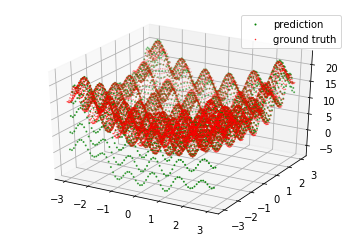

In [21]:
# Plot
X3 = XY_test[:,0].flatten()
Y3 = XY_test[:,1].flatten()

fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.plot_surface(X3, Y3, mu, rstride=1, cstride=1, linewidth=0, antialiased=False, color='g') #cmap=cm.plasma
ax.scatter3D(X3, Y3, mu, color='g', s=1)
ax.scatter3D(XY_plot[:,0].flatten(), XY_plot[:,1].flatten(), Z, color='r', s=0.2) # c=Z, cmap='viridis'
plt.legend(['prediction', 'ground truth'])

With $n_\text{samples}=400$, it finds a decent fit. With $n_\text{samples}=900$, the GP seems to be able to fit the function well in the region that training points were provided!

---

In [22]:
# Testing jupter notebook built-in commands
# http://ipython.readthedocs.io/en/stable/interactive/magics.html
%mkdir test
%cd test

mkdir: test: File exists
/Users/Kazu/Code/notebooks/test


In [23]:
%%time
import time
for _ in range(200):
    time.sleep(0.01) #[s]

CPU times: user 5.05 ms, sys: 4.93 ms, total: 9.99 ms
Wall time: 2.29 s


In [24]:
#TODO: plot some error metrics across n_samples
#TODO: take cross sections on a slice of x or y dimension to check fit closely

---

### Function approximation with neural networks

Related? https://ac.els-cdn.com/S1877050913002093/1-s2.0-S1877050913002093-main.pdf?_tid=03a1388a-089c-11e8-8dc0-00000aab0f26&acdnat=1517632860_5ae101a5d49e99d554ad7a1035da86a9

In [ ]:
import tensorflow as tf
from tqdm import tqdm #progress bar

In [ ]:
xy_min, xy_max = -5, 5
n_samples = 1000

In [ ]:
def create_data():
    X = np.random.uniform(xy_min, xy_max, n_samples).reshape((n_samples,1))
    Y = np.random.uniform(xy_min, xy_max, n_samples).reshape((n_samples,1))

    XY = np.concatenate((X,Y), axis=1)
    Z = rastrigin(XY.T)
    
    return XY.astype(np.float32), Z.astype(np.float32)

In [ ]:
def create_model():
    xy_coords = tf.placeholder(tf.float32, shape=[None, 2], name="xy-input")

    with tf.variable_scope("layer1"):
        hidden = tf.layers.dense(xy_coords, 512, activation=tf.nn.relu)
    with tf.variable_scope("layer2"):
        hidden = tf.layers.dense(hidden, 512, activation=tf.nn.relu)
    with tf.variable_scope("layer3"):
        hidden = tf.layers.dense(hidden, 512, activation=tf.nn.relu)    
    with tf.variable_scope("output"):
        z_val_pred = tf.layers.dense(hidden, 1)
        z_val_pred = tf.reshape(z_val_pred, [-1])
    
    return xy_coords, z_val_pred

In [ ]:
def create_training(z_val_pred):
    label_ph = tf.placeholder(tf.float32, shape=[None], name="z-labels")

    with tf.variable_scope("loss"):
        loss = tf.losses.mean_squared_error(labels=label_ph, predictions=z_val_pred)
        tf.summary.scalar('loss', loss)

    learning_rate = tf.placeholder(tf.float32, shape=[], name="learning_rate")
    with tf.variable_scope("training"):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss=loss)
        tf.summary.scalar('learning_rate', learning_rate)

    return train_op, loss, label_ph, learning_rate

In [ ]:
tf.reset_default_graph()
xy_coords, z_val_pred = create_model()
train, loss, labels, learning_rate = create_training(z_val_pred)
summary_op = tf.summary.merge_all()

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

lr = 1e-3

n_samples_total = 0
for i in tqdm(range(600)):
    xy_train, z_train = create_data()
    n_samples_total += n_samples
    
    _, cur_loss, cur_summaries = sess.run([train, loss, summary_op], 
        feed_dict={ xy_coords: xy_train, labels: z_train, learning_rate: lr})
    
    if i%50==0:
        print(cur_loss)
    
    if(cur_loss < 1): 
        break
print(cur_loss)

In [ ]:
query = np.array([1, 1], dtype=np.float32)
sess.run(z_val_pred, feed_dict={xy_coords: [query.flatten()]})

In [ ]:
# Plot learned function
N = 50
X = np.linspace(xy_min, xy_max, N)   
XY_test = xy_combinations(X, X).astype(np.float32)

Z_test = sess.run(z_val_pred, feed_dict={xy_coords: XY_test})
Z_tgt = rastrigin(XY_test.T)

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter3D(XY_test[:,0], XY_test[:,1], Z_test, color='g', s=1)
# ax.plot_trisurf(XY_test[:,0], XY_test[:,1], Z_test, color='g')

# ax.scatter3D(XY_test[:,0], XY_test[:,1], Z_tgt, color='r', s=1)
# ax.plot_trisurf(XY_test[:,0], XY_test[:,1], Z_tgt, color='r')

Neural network can't seem to learn the wavy-ness of a Rastrigin function. This is partly because of the mse loss.. Is this even a fair comparison?

### Bayesian optimization

Bayesian optimization is an optimization strategy that treats the objective function as a random function (here, a GP) and places a prior over it. It iteratively picks a sample point (based on the GP) and updates its model, in an effort to find the minimum point. It can be used for black-box functions (don't need to know structure, just have to be able to query at specific points), and doesn't require derivatives. Generally good for functions that are expensive to evaluate, since the uncertainty encoded in a GP model allows for balancing explorating-exploitation behavior. 

```
initialize D as empty prior
for t = 1, 2, ... do
    Find x_t by combining attributes of posterior distribution 
    in a utility function u and maximizing: 
    x_t = argmax_x u(x, D)
    
    Sample the objective function:
    y_t = f(x_t) + z_t
    
    Update the GP with new data (x_t, y_t_)
```

Utility function `u(x, D)` is also called acquisition function. We want to choose the next point $x$ where the mean is high (exploitation) and the variance is high (exploration, and assuming we're maximizing). Balance this tradeoff in a function: 
$$\mu(x) + \kappa \sigma(x)$$

Other acquisition functions: Bayesian expected losses, upper confidence bounds (UCB), Thompson sampling

For many applications, the acquisition function is much cheaper to evaluate than the real function. By using the acquisition function as a cheap proxy, and optimizing that, we can try to optimize the true objective function. 

Try Bayesian optimization for: 

* function minimization 
* multi-arm bandit?
* Also used in hyperparameter optimization for ML algorithms

References: 

* http://www.cs.ubc.ca/~nando/540-2013/lectures/l7.pdf
* https://en.wikipedia.org/wiki/Bayesian_optimization
* https://github.com/fmfn/BayesianOptimization
* https://www.iro.umontreal.ca/~bengioy/cifar/NCAP2014-summerschool/slides/Ryan_adams_140814_bayesopt_ncap.pdf

Example of Bayesian Optimization on Rastrigin function is shown below. 

Two acquisition functions. Note that we subtract term from $\mu$, because we're trying to minimize

* Gaussian Lower Confidence Bound (GLCB): $\mu(x) - \kappa \sigma(x)$
* UCB: $\mu(x) - \sqrt{\alpha \log(t+1) / 2T(i)}$, where $t$ is timestep and $T(i)$ is number of visits for a state $i$
    * Typically used in discrete bandit case; trying it here
    * See [here](http://banditalgs.com/2016/09/18/the-upper-confidence-bound-algorithm/) for theory behind this

Other options for acquisition functions: Gaussian Probability of Improvement, Gaussian Expected Improvement. See [here](http://efavdb.com/gaussian-processes/)

BO finds global minimum within a few queries. TODO compare to other people's implementations

Note that in this example implementation, I just evaluate the acquisition function over a grid and pick the best one. In practice, people usually run a global optimization algorithm (e.g. CMA-ES) on the acquisition function (i.e. an inner loop optimization): https://stats.stackexchange.com/questions/194166/practical-implementation-detail-of-bayesian-optimization

In [39]:
import scipy

#Test points on grid (for querying acquisition function)
n_probe = 51 # make sure this is odd [0, 0] is included
X_probe = np.linspace(-3, 3, n_probe)    
Y_probe = np.linspace(-3, 3, n_probe)    
XY_probe = xy_combinations(X_probe, Y_probe)
XY_probe.shape # number of points will be 70^2

s = 5e-5    # scale parameter / noise variance prior

# For UCB. Initialize with small number, to avoid divide by zero
# This still encourages UCB to query unvisited states first, but it's a hacky way to do this
# TODO how is it supposed to be done?
visit_counts = np.ones(XY_probe.shape[0]) * 1e-3 

for t in range(300):
    if t==0:
        query_point = np.random.uniform(-3, 3, 2).reshape((1,2)) # initial guess 
        XY_train = query_point
        y_train = rastrigin(query_point.T)
    else: 
        y_query = rastrigin(query_point.T) # "Expensive" evaluation
        XY_train = np.concatenate((XY_train, query_point), 0)
        y_train = np.concatenate((y_train, y_query), 0)

    ### Fit a GP to the data we have so far. # TODO is there a way to do this incrementally?
    K = se_kernel(XY_train, XY_train)
    K_ = se_kernel(XY_probe, XY_probe)
    L = np.linalg.cholesky(K + s*np.eye(XY_train.shape[0]))
    Lk = np.linalg.solve(L, se_kernel(XY_train, XY_probe))
    s2 = np.diag(K_) - np.sum(Lk**2, axis=0) 
    
    ### "Cheap" GP evaluation
    mu = np.dot(Lk.T, np.linalg.solve(L, y_train)) 
    sigma = np.sqrt(s2)
    
    ### Find acquisition function values at test points
    
    # Function 1: GLCB
    kappa = 0.5 
    acq = mu - kappa*sigma  
    
    # Function 2: UCB
#     alpha = 1.0
#     acq = mu - np.sqrt((alpha*np.log(t+1)) / (2*visit_counts))
        
    # Function 3: Gaussian Probability of Improvement
#     acq = -scipy.stats.norm.cdf(np.min(y_train), mu, sigma) # TODO make sure this works
        
    # Function 4: Expected improvement
    # TODO implement this "Practical Bayesian Optimization of Machine Learning Algorithms" claims this is empirically better behaved
    
    ### Pick next point to evaluate
    
    # Method 1: greedily pick min. prone to get stuck in local minima?
#     sample_idx = np.argmin(acq) 
    
    # Method 2: sample over softmax (Boltzmann?) distribution
    # -acq because the lower the acquisition function (some measure of expected value) is, we want higher prob
    sample_probs = np.exp(-acq - scipy.special.logsumexp(-acq))  
    sample_idx = np.random.multinomial(1, sample_probs).argmax()
            
    visit_counts[sample_idx] += 1

    query_point = XY_probe[sample_idx, :].reshape(1, 2)
    if t%20==0:
        print("Iter {}, best so far: {:.2f} at {}".format(t, y_train.min(), XY_train[np.argmin(y_train), :]))
#         print("Acquistion function at [0, 0]: {:.3f}. min acq: {:.3f}".format(acq[XY_probe.shape[0]//2], np.min(acq)))
        
print("Best: {:.2f} at {}".format(y_train.min(), XY_train[np.argmin(y_train), :]))        
print("Target: {:.2f} at [0, 0]".format(rastrigin(np.array([0, 0]))))

Iter 0, best so far: 3.69 at [0.7992 0.727 ]
Iter 20, best so far: 3.16 at [-0.84  1.92]
Iter 40, best so far: 0.64 at [1.08 0.84]
Iter 60, best so far: 0.11 at [0.96 0.84]
Iter 80, best so far: -1.46 at [ 0.   -1.08]
Iter 100, best so far: -1.98 at [ 0.   -0.96]
Iter 120, best so far: -1.98 at [ 0.   -0.96]
Iter 140, best so far: -1.98 at [ 0.   -0.96]
Iter 160, best so far: -1.98 at [ 0.   -0.96]
Iter 180, best so far: -1.98 at [ 0.   -0.96]
Iter 200, best so far: -1.98 at [ 0.   -0.96]
Iter 220, best so far: -1.98 at [ 0.   -0.96]
Iter 240, best so far: -1.98 at [ 0.   -0.96]
Iter 260, best so far: -1.98 at [ 0.   -0.96]
Iter 280, best so far: -1.98 at [ 0.   -0.96]
Best: -1.98 at [ 0.   -0.96]
Target: -3.00 at [0, 0]


In [ ]:
# Visualize what our model has learned so far about the underlying function
fig = plt.figure()
ax = fig.gca(projection='3d')

Z_probe = mu
# ax.scatter3D(XY_test[:,0], XY_test[:,1], Z_test, color='g', s=1)
ax.plot_trisurf(XY_probe[:,0], XY_probe[:,1], Z_probe, cmap='viridis')

On why BOs don't do well in high-dimensional spaces, from "High Dimensional Bayesian Optimization with Elastic Gaussian Process": 

> However, it has a serious limitation when the parameter space is high-dimensional as Bayesian optimization crucially depends on solving a global optimization of a surrogate utility function in the same sized dimensions. The surrogate utility function, known commonly as acquisition function is a continuous function but can be extremely sharp at high dimension - having only a few peaks marooned in a large terrain of almost flat surface.

Wang, Zoghi, Hutter, Matheson & de Freitas, IJCAI 2013 suggest a way to deal with many dimensions. Approach: choose a random embedding of the input dimensions and then optimize in the subspace

**Would this work for high-dim robot control? Or should we make some hand-made features to embed from high-dim to low-dim, like Akshara Rai paper? **